###  description: https://docs.google.com/document/d/1T2aP_k-PRLWp5s8VNxPwq7BTHBitVYh8BJzDS-pnRWs/edit?usp=sharing


In [ ]:
import numpy as np
import pandas as pd
import glob
import os
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
from bokeh.plotting import figure, show, output_file, ColumnDataSource
from mpl_toolkits.axes_grid1 import ImageGrid

%matplotlib inline

In [ ]:
dir_path='C:\\Users\\bazoo\\Dropbox (Personal)\\gilad_final_analysis\\publication\\Nature Cancer Yossi Figures\\Python Generated'
ICI_normalized = 'ICI_normalized_without_miRNA_and_Dummy.csv'
SI2_normalized = 'SI12_normalized_without_miRNA_and_Dummy.csv'
ribosomal_genes_path=os.path.join('C:\\Users\\bazoo\\data_processing_gilad\\normalized_all','ribosomal_genes.csv')

In [ ]:
OR = os.path.join(dir_path,'OR_gene_list.txt')
OR_df = pd.read_csv(OR, engine='python', sep='\t')
olfactory_gene_list = OR_df['Approved symbol'].values

In [ ]:
normalized_files = [os.path.join(dir_path,ICI_normalized), os.path.join(dir_path,SI2_normalized)]
dic={}
for norm_file in normalized_files:
    dic[os.path.basename(norm_file)] = pd.read_csv(norm_file)
ribosomal_genes=pd.read_csv(ribosomal_genes_path)

In [ ]:
df_ici = dic[ICI_normalized] 
df_si12 = dic[SI2_normalized] 
ribosomal_genes_array=ribosomal_genes.iloc[:,0].values
df_ici['isRibosomal'] = df_ici.gene_id.isin(ribosomal_genes_array)
df_si12['isRibosomal'] = df_si12.gene_id.isin(ribosomal_genes_array)

In [ ]:
df_ici.corr().to_csv(os.path.join(dir_path, 'ici_correlation_between_all_times.csv'))
df_si12.corr().to_csv(os.path.join(dir_path, 'si12_correlation_between_all_times.csv'))

In [ ]:
df_ici.head(1)

In [ ]:
df_all = df_ici.merge(df_si12, 
                      left_on=['target_id','gene_id', 'UID','seq','isRibosomal'], 
                      right_on=['target_id', 'gene_id', 'UID','seq', 'isRibosomal'], 
                      suffixes=('_ici', '_si12'))

In [ ]:
ici_times    = sorted([c for c in df_ici.columns if 'ICI' in c])
si12_times   = sorted([c for c in df_si12.columns if 'SI12' in c])

# We care only about T0, T1, T5, and T6

In [ ]:
ici_times

In [ ]:
si12_times

In [ ]:
zip(ici_times, si12_times)

In [ ]:
df_ici_sub = df_all[ici_times]
df_ici_sub = df_ici_sub.astype('float32')
plt.subplots(figsize=(5,10))
sns.heatmap(df_ici_sub.values,vmin=-1, vmax=2*df_ici_sub.values.std()+df_ici_sub.values.mean())
plt.show()

In [ ]:
df_si12_sub = df_all[si12_times]
df_si12_sub = df_si12_sub.astype('float32')
plt.subplots(figsize=(5,10))
sns.heatmap(df_si12_sub.values,vmin=-1, vmax=2*df_si12_sub.values.std()+df_si12_sub.values.mean())
plt.show()

# df_si12_sub contains the data points of SI12
# df_ici_sub contains the data points of ICI

In [ ]:
df_si12_sub.head()
df_ici_sub.head()

In [ ]:
def get_crisper_cs(medicine, time, df_temp, out_csv_name=None):
    group = '{0}-{1}'.format(medicine, time)
    cs = df_temp.groupby('gene_id').apply(lambda grp: np.mean(np.log2(grp[group])))
    if out_csv_name:
        pd.Series.sort_values(cs, ascending=True).to_csv(os.path.join(dir_path,'outputs',out_csv_name))
    return pd.Series.sort_values(cs, ascending=True)

In [ ]:
cs_ici  = dict()
cs_si12 = dict()
for i in [1,2,3,4,5,6]:
    cs_ici[i]  = get_crisper_cs('ICI',  'T{0}'.format(i), df_all, os.path.join(dir_path,'temp.csv'))
    cs_si12[i] = get_crisper_cs('SI12', 'T{0}'.format(i), df_all, os.path.join(dir_path,'temp.csv'))

# Debug

In [ ]:
plt.plot(cs_ici[1].values)
plt.show()

# ribosomal analysis

In [ ]:
def ribosomal_plot(arrays, filename=''):
    sns.set(font_scale=2)
    sns.set_style("ticks")

    for arr in arrays:
        plt.figure(figsize=(10,10))
        df=arr[0]
        drugname = arr[1]
        legend_dict = arr[2]
        for a in tuple(*arr[3:]):
            sns.kdeplot(np.log2(1+df[a].values), cumulative = True, linewidth=1, label='All Genes {0}'.format(legend_dict[a]))
            #sns.kdeplot(df[a], cumulative = True, linewidth=1)
        #plt.legend(fontsize='x-large', title_fontsize='400')
        plt.legend(fontsize=15) # using a size in points
        # We change the fontsize of minor ticks label 
        # TODO
        # plt.savefig('{0}_{1}_{2}_scatter.png'.format(drug_name,ratio_id,desc), dpi=400, bbox_inches='tight')
        plt.title('{0} all genes CDF'.format(drugname))
        plt.savefig(os.path.join(dir_path,'{0} all genes CDF.svg'.format(drugname)), dpi=1200, bbox_inches='tight')
        plt.show()

        plt.figure(figsize=(10,10))
#         df=arr[0]
        for a in tuple(*arr[3:]):
            df_r = df[df.isRibosomal==True]
            df_not_r = df[df.isRibosomal==False]
            sns.kdeplot(np.log2(1+df_r[a].values),  cumulative = True, linewidth=1, marker='o', label='{0} ribosomal genes'.format(legend_dict[a]))
            sns.kdeplot(np.log2(1+df_not_r[a].values), cumulative = True, linewidth=1,          label='{0} Nonribosomal genes'.format(legend_dict[a]))
            # sns.kdeplot(df[a], cumulative = True, linewidth=1)
        #plt.legend(fontsize='x-large', title_fontsize='400')
        plt.legend(fontsize=15) # using a size in points
        # We change the fontsize of minor ticks label 
        
        # TODO
        # plt.savefig('{0}_{1}_{2}_scatter.png'.format(drug_name,ratio_id,desc), dpi=400, bbox_inches='tight')
        plt.title('{0} ribosomal vs. other genes CDFs'.format(drugname))
        plt.savefig(os.path.join(dir_path,'{0} ribosomal vs. other genes CDFs{1}.svg'.format(drugname,filename)), dpi=1200, bbox_inches='tight')
        plt.show()
    

# filtering genes with CS bokeh for loop for SI12 stringent  
## Gilad filtering algo

In [ ]:
def bokeh_gilad_algo_plot(arr, df, drug_name, show_browser=False, filter_olfactory = False):
    for element in arr:
        control       = element[2]
        experiment    = element[1]
        ratio_id      = element[0]

        mean_ratio    = df.groupby('gene_id').apply(lambda grp: np.mean(grp[ratio_id]))
        mean_trend    = df.groupby('gene_id').apply(lambda grp: np.count_nonzero(np.sign(np.log2(np.mean(grp[ratio_id]))) == 
                                                                          np.sign(np.log2(grp[ratio_id]))))


        df['gene_id'].value_counts()
        
        if filter_olfactory:
            print(np.sum(df.gene_id.isin(olfactory_gene_list)))
            df = df[df.gene_id.isin(olfactory_gene_list)]

#         display(df[df['gene_id'] == 'OR6B2'])
        gene_with_four_trend = pd.Series(mean_trend).where(lambda x : x>3).dropna().keys()
        df_trend_filter = df[df.gene_id.isin(gene_with_four_trend)]
        df_trend_filter = df_trend_filter.drop(df_trend_filter[df_trend_filter[control] < 3].index)


        extreme_ratio   = df_trend_filter.groupby('gene_id').apply(lambda grp: 
                                                                np.min(grp[ratio_id]) if np.log2(np.mean(grp[ratio_id])) <0 
                                                                else np.max(grp[ratio_id]))

        
        extreme_ratio = extreme_ratio.sort_values(ascending=True)
        extreme_ratio_df = extreme_ratio.to_frame().reset_index()
#         display(extreme_ratio_df [extreme_ratio_df ['gene_id'] == 'OR6B2'])
        #display(extreme_ratio_df)
        extreme_ratio.to_csv(os.path.join(dir_path,'outputs', 'stinger_filter_{0}_{1}_filter_olfactry_genes_{2}.csv'.format(drug_name,ratio_id, filter_olfactory))) 

        TOOLS="hover,crosshair,pan,wheel_zoom,zoom_in,zoom_out,box_zoom,undo,redo,reset,tap,save,box_select,poly_select,lasso_select,"
            #TOOLS="hover,pan,wheel_zoom,zoom_in,zoom_out,box_zoom,undo,tap,save"
        x = np.linspace(0, 1, len(extreme_ratio.values), endpoint=False)
        y = np.log2(extreme_ratio.values)
        source = ColumnDataSource(data=dict(
            x=x, 
            #x=d_2['log2FC'].tolist(), 
            # y=series_cs.values,
            y=y,
            desc=extreme_ratio.keys(),
            # fill_color=d_2_mean['color'].tolist(), 
            #fill_alpha=0.6, 
            #line_color=None)
        ))

        TOOLTIPS = [
            ("index", "$index"),
            ("(x,y)", "($x, $y)"),
            ("desc", "@desc"),
            #("fill_color", "@fill_color"),
        ]

        p = figure() 
        p = figure(tools=TOOLS, plot_width=1000, plot_height=1000, tooltips=TOOLTIPS)

        p.title.text = '{0}: ratio {1} over {2} | stringently filtered sgRNA'.format(drug_name, experiment, control)

        p.circle(x='x',y='y', size=10, source=source, line_color="#3288bd", fill_color="#3288bd", line_width=1, fill_alpha=0.6, line_alpha=0.6)
        #p.xaxis[0].ticker.base = 2 
        #p.xaxis[0].formatter.ticker = p.xaxis[0].ticker 
        output_file(os.path.join(dir_path,"log2fc_score_{0}_{1}_gilad_algo_filter_olfactry_genes_{2}.html".format(drug_name,ratio_id,filter_olfactory)), 
                    title="log2fc_score_{0}_{1}".format(drug_name,ratio_id))
        p.yaxis.axis_label = 'Log2FC {0}'.format(ratio_id)
        p.xaxis.axis_label = 'gene rank'
        if show_browser:
            show(p)  # open a browser 
                # plot 
        
        plt.figure(figsize=(2, 6), dpi=1200)
        plt.scatter(x, y, alpha=0.6, s=100, c='#3288bd')
#         plt.xlabel('Log2 fold change',fontsize=15, fontname="sans-serif", fontweight="bold")
#         plt.ylabel('Number of sgRNAs with {0}\'s trend'.format(desc), fontsize=15, fontname="sans-serif", fontweight="bold")
        plt.title('{0}: ratio {1} over {2}'.format(drug_name, experiment, control))

#         plt.xticks(np.arange(-2,2.5,0.5), fontsize=15, fontname="sans-serif")
#         plt.yticks(np.arange(1,7,1, dtype=np.int32), fontsize=15, fontname="sans-serif") 

        #ax.set_xlim(-2.0, 2.0)
        #ax.set_xscale('log', basex=2)
        plt.xticks(np.arange(0,0.5,0.1), fontsize=10, fontname="sans-serif")
        plt.yticks(np.arange(-10,1,1), fontsize=10, fontname="sans-serif")
        
        # ax.set_xticks(np.arange(-0.1,0.5,0.1), minor=True)
        plt.ylim([-6.0,-1.0])
        plt.xlim([-0.1, 0.2])
        ax = plt.gca()
#         ax.tick_params(axis='x',which='both',direction='out',bottom=True,length=5)
        ax.xaxis.set_minor_locator(AutoMinorLocator())
        ax.yaxis.set_minor_locator(AutoMinorLocator())

        plt.tight_layout()
        plt.savefig(os.path.join(dir_path,'{0}_{1}_algo.png'.format(drug_name,ratio_id)), bbox_inches='tight')
        plt.show()

In [ ]:
def bokeh_terrace_plot(arr, df, drug_name, show_browser=False, filter_olfactory = False):
    for element in arr:
        control       = element[2]
        experiment    = element[1]
        ratio_id      = element[0]

        mean_trend_control   = df.groupby('gene_id').apply(lambda grp: np.mean(grp[control]))
        mean_trend_exper     = df.groupby('gene_id').apply(lambda grp: np.mean(grp[experiment]))
        trend_mean_agreement = df.groupby('gene_id').apply(lambda grp: 
                                                         np.count_nonzero(np.sign(np.log2(np.mean(grp[ratio_id]))) == 
                                                                          np.sign(np.log2(grp[ratio_id]))))

        # overriding the temp data frames
        df1 = pd.DataFrame({'gene_id':mean_trend_control.index,   'value1':mean_trend_control.values})
        df2 = pd.DataFrame({'gene_id':mean_trend_exper.index,     'value2':mean_trend_exper.values})
        df3 = pd.DataFrame({'gene_id':trend_mean_agreement.index, 'trend':trend_mean_agreement.values})
        d_2_mean = pd.merge(df1, df2, left_on='gene_id', right_on='gene_id')

        d_2_mean['log2FC']  = np.log2((1+d_2_mean['value2'])/(1+d_2_mean['value1']))
        d_2_mean = pd.merge(d_2_mean, df3, left_on='gene_id', right_on='gene_id')

        d_2_toplot = [(d_2_mean,'mean')]

#         print(control, experiment, ratio_id)
#         display(d_2_mean[d_2_mean['gene_id'] == 'OR6B2'])
#         display(df[df['gene_id'] == 'OR6B2'])
#         display(df[df['gene_id'] == 'OR6B2'].mean())
        
        for d_2,desc in d_2_toplot:
#             d_2.loc[(d_2['log2FC'] >= np.log2(1.5)),  'color'] = "green"  # upregulated   old condition
#             d_2.loc[(d_2['log2FC'] <= np.log2(0.5)),  'color']  = "red"   # downregulated old condition

            d_2.loc[(d_2['log2FC'] >= 0.5),    'color']  = "green"    # upregulated > log2(x)=0.5
            d_2.loc[(d_2['log2FC'] <= -0.5),   'color']  = "red"      # downregulated < log2(x)=-0.5
            d_2['color'].fillna('grey', inplace=True) # intermediate
            
            if filter_olfactory:
                print(np.sum(d_2.gene_id.isin(olfactory_gene_list)))
                d_2 = d_2[d_2.gene_id.isin(olfactory_gene_list)]
            # to reduce the noise, filter out genes with low expression counts across treatments 
            # (say, < 10 normalized expression count)
            # you can change this number as per your requirement and based on expression unit 
            # value1 and value2 represents counts for stress and control treatments respectively

            # d_2 = d_2.loc[(d['value1'] >= 10) & (d['value2'] >= 10)]
            d_2 = d_2.loc[(d_2['trend'] < 10)] # 
            # d_2 = d_2.loc[(d_2['log2FC'] > np.sqrt(1.05)) | (d_2['log2FC'] < np.log2(0.95))]

            # plot 
            plt.figure(figsize=(10, 5), dpi=1200)
            plt.scatter(d_2['log2FC'], d_2['trend'], c=d_2['color'], alpha=0.6, s=100)
            plt.xlabel('Log2 fold change',fontsize=15, fontname="sans-serif", fontweight="bold")
            plt.ylabel('Number of sgRNAs with {0}\'s trend'.format(desc), fontsize=15, fontname="sans-serif", fontweight="bold")
            plt.title('{0}: ratio {1} over {2}'.format(drug_name, experiment, control))

            #ax = plt.gca()
            plt.xticks(np.arange(-2,2.5,0.5), fontsize=15, fontname="sans-serif")
            plt.yticks(np.arange(1,7,1, dtype=np.int32), fontsize=15, fontname="sans-serif") 
            
            #ax.set_xlim(-2.0, 2.0)
            #ax.set_xscale('log', basex=2)
            plt.xlim([-2.0,2.0])


            plt.tight_layout()
            plt.savefig(os.path.join(dir_path,'{0}_{1}_{2}_scatter_filtered_olfactory_genes_{3}.png'.format(drug_name,ratio_id,desc,filter_olfactory)), bbox_inches='tight')
            plt.show()

        #    colors = [
        #        "#%02x%02x%02x" % (int(r), int(g), 150) for r, g in zip(50+2*x, 30+2*y)
        #    ]

            TOOLS="hover,crosshair,pan,wheel_zoom,zoom_in,zoom_out,box_zoom,undo,redo,reset,tap,save,box_select,poly_select,lasso_select,"
            #TOOLS="hover,pan,wheel_zoom,zoom_in,zoom_out,box_zoom,undo,tap,save"

            source = ColumnDataSource(data=dict(
                x=np.power(2,d_2['log2FC'].tolist()), 
                #x=d_2['log2FC'].tolist(), 
                y=d_2['trend'].tolist(),
                desc=d_2['gene_id'].tolist(),
                fill_color=d_2['color'].tolist(), 
                #fill_alpha=0.6, 
                #line_color=None
            ))

            TOOLTIPS = [
                ("index", "$index"),
                ("(x,y)", "($x, $y)"),
                ("desc", "@desc"),
                ("fill_color", "@fill_color"),
            ]

            p = figure(tools=TOOLS, plot_width=1000, plot_height=1000, x_axis_type="log", 
                       tooltips=TOOLTIPS,  x_range=(0.125, 8))

            p.title.text = '{0}: ratio {1} over {2}'.format(drug_name, experiment, control)

            # p = figure(tools=TOOLS, plot_width=1000,  tooltips=TOOLTIPS)
            p.circle(x='x',y='y', fill_color='fill_color', size=10, source=source)
            p.xaxis[0].ticker.base = 2 
            p.xaxis[0].formatter.ticker = p.xaxis[0].ticker 
            output_file(os.path.join(dir_path,"terrace_plot_{0}_{1}_{2}_filtered_olfactory_genes_{3}.html".format(drug_name,ratio_id, desc, filter_olfactory)), 
                    title="terrace_plot_{0}_{1}_{2}".format(drug_name,ratio_id, desc))            
            p.xaxis.axis_label = 'ratio drug/control'.format(ratio_id)
            p.yaxis.axis_label = 'Number of sgRNAs with {0}\'s trend'.format(desc)
            if show_browser:
                show(p)  # open a browser 

            d_2['zscored_log2FC'] = (d_2['log2FC'] - np.mean(d_2['log2FC']))/np.std(d_2['log2FC'])

            sns.distplot(np.array(d_2['log2FC']))
            d_2.to_csv(os.path.join(dir_path,'outputs', '{0}_{1}_olfactory_{2}.csv'.format(ratio_id, desc, filter_olfactory)))


# z-score for specific genes

In [ ]:
def z_score_plot(df, experiemnts_rows, markers, title, savefile=None):
    import matplotlib.pyplot as plt
    sns.set(font_scale=3)
    sns.set_style("ticks")
    # sns.set_palette("magma_r")
    sns.set_palette("winter", len(experiemnts_rows))


    f, ax = plt.subplots(figsize=(30,30))
    labels = df['target_id'].values

    x = np.arange(1,10*(len(labels)),10)
    for idx, row in enumerate(experiemnts_rows):
        y = df[row].values
        y = np.clip(y, a_min = -2, a_max = 2) 
        ax.scatter(x, y, s =200, alpha=0.95, label=row, marker=markers[idx % len(markers)])
    # You can specify a rotation for the tick labels in degrees or with keywords.
    plt.xticks(x, labels, rotation='vertical')
    # Pad margins so that markers don't get clipped by the axes
    plt.margins(0.5)
    plt.legend(experiemnts_rows)
    # Tweak spacing to prevent clipping of tick-labels
    plt.subplots_adjust(bottom=0.5)
    plt.ylim([-2.5,2.5])
    plt.axhline(y=0.0, color='r')
    plt.title(title)
    
    plt.yticks(np.arange(-2,2.25, step=0.25))

    plt.show()
    if savefile:
        f.savefig(savefile)

In [ ]:
# sns.palplot(sns.color_palette())

In [ ]:
# #control_rows=['T0_A_2','T0_B']
# control_rows=['T0_A_2']


# # list_geneids = ['NCOA1', 'RHOA', 'Rab25','NCOA2','VAV1','cdk4','NCOA3',
# #                 'RIC8A','OR5I1', 'DNMT3A','ATAD2','POLRMT','WASH1', 
# #                 'CYP4F8','VAV1']

# #list_geneids=['NCOA1']
# # list_geneids = ['NCOA1','NCOA2','NCOA3','NCOA4'] # to be read from a file

# # PDL-1/PDL-2
# list_geneids = ['CD47', 'ADORA2A', 'BTLA','CD28',
#                 'CD247', 'IDO1', 'IFNG','MTOR','IDO1',
#                 'STAT1', 'STAT2','STAT3','STAT4','STAT5A','STAT5B','STAT6','STATH',
#                 'CAMK2A','CAMK2B','CAMK2G','CAMK2D',
#                'IRF1', 'IRF9', 'NFKB1', 'PIK3CA', 'PTEN', 'IPCEF1', 'PTPN6', 'PTPN11', 'BCL2',
#                'XPNPEP1','XPNPEP2','XPNPEP3']


                



# markers=['v', '^', 'o', '*', '+', 'x'] 
# flatten = lambda l: [item for sublist in l for item in sublist]

In [ ]:
# # experiemnts_rows = [['T1_2_B', 'T1_1_A'],['T3_2_A', 'T3_1_A'],  
# #                     ['T4_2_A', 'T4_1_A'], ['T6_2_A', 'T6_1_A'], ['T5_2_A', 'T5_1_A'], ['T2_2_A', 'T2_1_A']]

# experiemnts_rows = [['T1_1_A', 'T1_2_B', 'T2_1_A','T2_2_A', 'T3_1_A', 'T3_2_A', 
#                      'T4_1_A','T4_2_A', 'T5_1_A', 'T5_2_A', 'T6_1_A','T6_2_A' ]]


# drug_name='SI12'

# for row in flatten(experiemnts_rows): 
#     print("{0: >10} - mu = {1:.2f} sigma = {2:.2f}".format(row.strip(), np.mean(df_si12[row]),np.std(df_si12[row])))

# for couple in experiemnts_rows:
#     for geneid in list_geneids:
#         geneid = geneid.upper() 
#         df = df_si12.copy()
#         df = df.sort_values(by=['target_id'])
#         tmp = []
#         tmp = control_rows.copy()
#         tmp.extend(couple)
#         for row in tmp:
#             print(row, np.mean(df_si12[row]),np.std(df_si12[row]))
#             df[row] = (df_si12[row] - np.mean(df_si12[row]))/np.std(df_si12[row])
#             df = df.loc[df['gene_id'].isin([geneid])]
#         display(df[flatten(experiemnts_rows) + ['gene_id', 'target_id']])
#         z_score_plot(df, tmp, markers, '{0} - {1}'.format(drug_name, geneid),
#                      os.path.join(dir_path,'{0}_{1}_{2}_z-score_plot.png'.format("_".join(tmp),drug_name, geneid)))
        


In [ ]:
# # experiemnts_rows = [['T1_3_C', 'T1_1_A'], ['T2_3_A', 'T2_1_A'], ['T3_3_B', 
# #                     'T3_1_A'], ['T4_3_A', 'T5(4)_1_A'], ['T5_3_A', 'T6(5)_1_A'], ['T6_3_C', 'T7(6)_A_1']]


# experiemnts_rows = [['T1_3_C', 'T1_1_A', 'T2_3_A', 'T2_1_A', 'T3_3_B', 
#                     'T3_1_A', 'T4_3_A', 'T5(4)_1_A', 'T5_3_A', 'T6(5)_1_A', 
#                      'T6_3_C', 'T7(6)_A_1']]

# drug_name='ICI'

# for row in flatten(experiemnts_rows): 
#     print("{0: >10} - mu = {1:.2f} sigma = {2:.2f}".format(row.strip(), np.mean(df_ici[row]),np.std(df_ici[row])))


# for couple in experiemnts_rows:
#     for geneid in list_geneids:
#         geneid = geneid.upper() 
#         df = df_ici.copy()
#         df = df.sort_values(by=['target_id'])
#         tmp = []
#         tmp = control_rows.copy()
#         tmp.extend(couple)
#         for row in tmp:
#             print(row, np.mean(df_ici[row]),np.std(df_ici[row]))
#             df[row] = (df_ici[row] - np.mean(df_ici[row]))/np.std(df_ici[row])
#             df = df.loc[df['gene_id'].isin([geneid])]
#         display(df[flatten(experiemnts_rows) + ['gene_id', 'target_id']])
#         z_score_plot(df, tmp, markers, '{0} - {1}'.format(drug_name, geneid),
#                      os.path.join(dir_path,'{0}_{1}_{2}_z-score_plot.png'.format("_".join(tmp),drug_name, geneid)))

In [ ]:
# list_geneids

# PD-L1/2 and Cell Stress

Name	Screening Name
PD-L1/2	
IRF1	IRF1
IRF9	IRF9
STAT1	STAT1
STAT2	STAT2
STAT3	STAT3
JAK1	JAK1
JAK2	JAK2
CD274	CD274
CD273	CD273
IDO1	IDO1
	
	
	
	
CELL STRESS	
NFKB1 	NFKB1 
NFKB2	NFKB2
XBP1	XBP1
CHOP	DDIT3
ATF4	ATF4
ERN1	ERN1

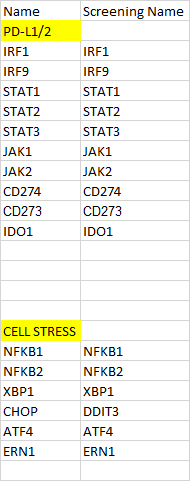

In [ ]:
# pdl1_2_list      = ['IRF1', 'IRF9', 'STAT1', 'STAT2', 'STAT3', 'JAK1', 'JAK2', 'CD274', 'CD273', 'IDO1'] 
# cell_stress_list = ['NFKB1', 'NFKB2', 'XBP1', 'DDIT3', 'ATF4', 'ERN1'] 
# memory_gene_list = ['CAMK2A','CAMK2B','CAMK2G','CAMK2D'] 



In [ ]:
def specific_gene_heatmap(orig_df, gene_list, times, drug_name, list_desc):
    orig_df['inListgenes'] = orig_df.gene_id.isin(gene_list)
    tmp_df  = orig_df[orig_df.inListgenes==True]
    tmp_df  = tmp_df[times + ['target_id', 'gene_id']].groupby('gene_id').apply(lambda x: x.mean())
    tmp_df  = tmp_df.reset_index()
    tmp_df  = tmp_df.astype(dict(zip(times,[np.float32]*len(times))))
    sns.set(font_scale=1.6)

    g = sns.clustermap(tmp_df[times].values, 
                xticklabels=tmp_df[times].columns,
                yticklabels=tmp_df['gene_id'], cmap=sns.color_palette("coolwarm", 9),figsize=(10,10), 
                vmin=0, vmax=2.0, col_cluster=False, row_cluster=True, center=1.0, annot=True,  fmt='.2f')
    g.fig.suptitle('{0}-{1} - Mean Gene Enrichment'.format(drug_name, list_desc)) 
    g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), rotation=0)
    
    plt.savefig(os.path.join(dir_path,'heatmaps of specific pathways','{0}-{1} - Mean Gene Enrichment.png'.format(drug_name, list_desc.replace('/','_'))), bbox_inches='tight')
    
    plt.show()

In [ ]:
# specific_gene_heatmap(df_si12, pdl1_2_list, si12_times, 'SI12', 'PD-L1/2')
# specific_gene_heatmap(df_ici,  pdl1_2_list, ici_times, 'ICI', 'PD-L1/2')

# specific_gene_heatmap(df_si12, cell_stress_list, si12_times, 'SI12', 'Cell Stress')
# specific_gene_heatmap(df_ici,  cell_stress_list, ici_times, 'ICI', 'Cell Stress')


# specific_gene_heatmap(df_si12, memory_gene_list, si12_times, 'SI12', 'CAMK2')
# specific_gene_heatmap(df_ici,  memory_gene_list, ici_times, 'ICI', 'CAMK2')

In [ ]:
# # https://www.stemcell.com/media/files/wallchart/WA28226-Breast_Cancer.pdf

# bc_receptors   = ['IGF1R', 'EGFR', 'USH2A', 'EGFR', 'FGFR1', 'FGFR2', 'FGFR3', 'FGFR4', 'CDH1'] 
# bc_key_genes   = ['BRAF','MDM2','CDK4', 'MYC', 'MYB', 'NCOA3', 'CDK4', 'TP53','PIK3CA','GATA3','MAP3K1','MLL3','CDH1','USH2A','PTEN','RUNX1','MAP2K4','NCOR1','RB1','TBX3','PIK3R1','CTCF','NF1','SF3B1','AKT1','CBFB','FOXA1','CDKN1B']
# hic_genes = ['CTCF', 'RAD21', 'YY1', 'ZNF143', 'SMC3', 'CTCFL','POLR2A', 'MAZ','ZC3H11A']


# specific_gene_heatmap(df_si12, bc_receptors, si12_times, 'SI12', 'Key Receptors in BC')
# specific_gene_heatmap(df_ici,  bc_receptors, ici_times, 'ICI', 'Key Receptors in BC')

# specific_gene_heatmap(df_si12, bc_key_genes, si12_times, 'SI12', 'Key Signaling Genes in BC')
# specific_gene_heatmap(df_ici,  bc_key_genes, ici_times, 'ICI', 'Key Signaling Genes in BC')


# specific_gene_heatmap(df_si12, hic_genes, si12_times, 'SI12', 'Genes From Rao 2014 Cell (Aiden Lab)')
# specific_gene_heatmap(df_ici,  hic_genes, ici_times, 'ICI', 'Genes From Rao 2014 Cell (Aiden Lab)')


In [ ]:
# len(bc_key_genes)

In [ ]:
# # https://www.nature.com/articles/s41557-019-0278-x
# Ub_genes   = ['UBB', 'UBC', 'UBA52','RPS27A'] 
# specific_gene_heatmap(df_si12, Ub_genes, si12_times, 'SI12', 'Ubiquitin')
# specific_gene_heatmap(df_ici,  Ub_genes, ici_times, 'ICI', 'Ubiquitin')

# publication plots

1. Ribosomal genes' CDF with T0, T_1 control, T5 control, T6 contorl 

SI12:

`T1-1-A, T1-2-B`

`T5-1-A, T5-2-A`

`T6-1-A, T6-2-A`

ICI

`T1-1-A, T1-3-C`

`T5-1-A, T4-3-A`

`T6-1-A, T5-3-A`

2. Two figures per each drug (SI12 ICI): Terrace for T0, T1, T5, and T6 [with the np.mean, fix axes (2^-4, 2^4), squre, svg, clean T0 (explanation bellow*) ] in total $2*3 + 1 = 7 $graphs
3. Two figures of bokeh_gilad_algo_plot per each drug (SI12 ICI): for T1,  T5, and T6 [with the np.mean, fix axes, squre, svg, clean T0 (explanation bellow*) ] $2*3 = 6 $ graphs
4. CDF of dummy sgRNA at T0, T_1 control, T5 control, T6 contorl
5. to do z-score for the genes https://www.biorxiv.org/content/biorxiv/early/2016/07/21/065094.full.pdf of log(p_droput)

`* Avergae the two timepoint at T0 (T0_A_2, T0_B) and then drop whatever is less than 10 which means the sgRNA palsmoid didn't even affect the cell (to drop the row) `


In [ ]:
cols_t0 = ['T0_A_2', 'T0_B']
number_of_reads = {'T0_A_2':83855681, 'T0_B': 71652000}
# (count * Num reads)/10^7 > 60

df_ici['T0-averaged']  = (df_ici['T0_A_2']*number_of_reads['T0_A_2']  + df_ici['T0_B']*number_of_reads['T0_B'])/(2e7)
df_si12['T0-averaged'] = (df_si12['T0_A_2']*number_of_reads['T0_A_2'] + df_si12['T0_B']*number_of_reads['T0_B'])/(2e7)

df_ici['effctive-plasmid']  = df_ici['T0-averaged']>60
df_si12['effctive-plasmid'] = df_si12['T0-averaged']>60

In [ ]:
# mapping the names of publication vs. actual experiment 
control_ici={0: 'T0-averaged' , 1:'T1_1_A' ,4: 'T5(4)_1_A', 5: 'T6(5)_1_A'}
control_si12={0:'T0-averaged' , 1:'T1_1_A' ,5: 'T5_1_A', 6: 'T6_1_A'}

publication_time_mapping = ({'T0-averaged':'T0' , 'T1_1_A':'T1' ,'T5(4)_1_A': 'T4', 
             'T6(5)_1_A':'T5', 'T5_1_A': 'T5','T6_1_A':'T6' })

def plot_cdf(ici_times=[], si12_times=[], filename=''):
    arrays = [(df_ici[df_ici['effctive-plasmid'] == True], 'ICI', publication_time_mapping,  []), 
          (df_si12[df_si12['effctive-plasmid'] == True], 'SI12', publication_time_mapping,  [])]  
    
    for i in si12_times:
        column_names = list(arrays[1][0].columns)    
        arrays[1][3].extend([column_names[column_names.index(control_si12[i])]])

    for i in ici_times:
        column_names = list(arrays[0][0].columns)    
        arrays[0][3].extend([column_names[column_names.index(control_ici[i])]])
    
    ribosomal_plot(arrays, filename)

In [ ]:
def correaltion_two_times(df, time1,time2, filename=''):
    sns.set(font_scale=2)
    sns.set_style("ticks")
    plt.figure(figsize=(10,10))

    df = df[df['effctive-plasmid'] == True]
    df = df[df['T0_B'] < 8000]
    sns.regplot(x=time1, y=time2, data=df, ci=99);
    plt.title('T0 correlation')
    plt.savefig(os.path.join(dir_path,'Time 0 correaltion {0}.svg'.format(filename)), dpi=1200, bbox_inches='tight')
    plt.close()
correaltion_two_times(df_si12, time1='T0_A_2',time2='T0_B', filename='correaltion1')

In [ ]:
if False:
    sns_plot = sns.pairplot(df_si12[['T0_A_2', 'T0_B', 'T1_1_A',
           'T1_2_B', 'SI12-T1', 'T2_1_A', 'T2_2_A', 'SI12-T2', 'T3_1_A', 'T3_2_A',
           'SI12-T3', 'T4_1_A', 'T4_2_A', 'SI12-T4', 'T5_1_A', 'T5_2_A', 'SI12-T5',
           'T6_1_A', 'T6_2_A', 'SI12-T6', 'T0-averaged']])
    sns_plot.savefig(os.path.join(dir_path,'Outputs','SI12_pairplot.png'))

In [ ]:
if False:
    sns_plot = sns.pairplot(df_ici[['T0_A_2', 'T0_B', 'T1_1_A',
           'T1_3_C', 'ICI-T1', 'T2_1_A', 'T2_3_A', 'ICI-T2', 'T3_1_A', 'T3_3_B',
           'ICI-T3', 'T5(4)_1_A', 'T4_3_A', 'ICI-T4', 'T6(5)_1_A', 'T5_3_A',
           'ICI-T5', 'T7(6)_A_1', 'T6_3_C', 'ICI-T6', 'T0-averaged',]])
    sns_plot.savefig(os.path.join(dir_path,'Outputs','ICI_pairplot.png'))


In [ ]:
plot_cdf(si12_times=[0,1],ici_times=[0,1], filename='1')
plot_cdf(si12_times=[0,5],ici_times=[0,4], filename='2')
plot_cdf(si12_times=[0,6],ici_times=[0,5], filename='3')

In [ ]:
with sns.axes_style("darkgrid"):
    arr = []
    drug_name='SI12'
    df=df_si12[df_si12['effctive-plasmid'] == True]
    for i in [1,5,6]:
        column_names = list(df.columns)
        timestamp='{1}-T{0}'.format(i,drug_name)
        arr.append([timestamp, 
                    column_names[column_names.index(timestamp)-1], 
                    column_names[column_names.index(timestamp)-2]])
    print(arr)

    bokeh_terrace_plot(arr, df, drug_name, True, False)

In [ ]:
with sns.axes_style("darkgrid"):
    arr = []
    drug_name='SI12'
    df=df_si12[df_si12['effctive-plasmid'] == True]
    for i in [1,5,6]:
        column_names = list(df.columns)
        timestamp='{1}-T{0}'.format(i,drug_name)
        arr.append([timestamp, 
                    column_names[column_names.index(timestamp)-1], 
                    column_names[column_names.index(timestamp)-2]])
    print(arr)

    bokeh_terrace_plot(arr, df, drug_name, True, True)

In [ ]:
with sns.axes_style("darkgrid"):
    arr = []
    drug_name='ICI'
    df=df_ici[df_ici['effctive-plasmid'] == True]
    for i in [1,4,5]:
        column_names = list(df.columns)
        timestamp='{1}-T{0}'.format(i,drug_name)
        arr.append([timestamp, 
                    column_names[column_names.index(timestamp)-1], 
                    column_names[column_names.index(timestamp)-2]])
    print(arr)
    bokeh_terrace_plot(arr, df, drug_name, True, False)


In [ ]:
with sns.axes_style("ticks"):
    arr = []
    drug_name='SI12'
    df=df_si12[df_si12['effctive-plasmid'] == True]
    for i in [1,5,6]:
        column_names = list(df.columns)
        timestamp='{1}-T{0}'.format(i,drug_name)
        arr.append([timestamp, 
                    column_names[column_names.index(timestamp)-1], 
                    column_names[column_names.index(timestamp)-2]])

    print(arr)

    bokeh_gilad_algo_plot(arr, df, drug_name, True, False)


In [ ]:
with sns.axes_style("ticks"):
    arr = []
    drug_name='SI12'
    df=df_si12[df_si12['effctive-plasmid'] == True]
    for i in [1,5,6]:
        column_names = list(df.columns)
        timestamp='{1}-T{0}'.format(i,drug_name)
        arr.append([timestamp, 
                    column_names[column_names.index(timestamp)-1], 
                    column_names[column_names.index(timestamp)-2]])

    print(arr)

    bokeh_gilad_algo_plot(arr, df, drug_name, True, True)


In [ ]:
with sns.axes_style("ticks"):
    arr = []
    drug_name='ICI'
    df=df_ici[df_ici['effctive-plasmid'] == True]
    for i in [1,4,5]:
        column_names = list(df.columns)
        timestamp='{1}-T{0}'.format(i,drug_name)
        arr.append([timestamp, 
                    column_names[column_names.index(timestamp)-1], 
                    column_names[column_names.index(timestamp)-2]])

    print(arr)

    bokeh_gilad_algo_plot(arr, df, drug_name, True, False)

In [ ]:
def heatmap_yosi(dfs):
    count = 0
    fig  = plt.figure(figsize=(5*3, 30))
    for sheet_name,df in dfs.items():
        df.sort_values('log2FC (SI12)')
        grid = ImageGrid(fig, 131+count, nrows_ncols=(1, 1),
                         direction='row', axes_pad=0.05, add_all=True,
                         label_mode='1', share_all=False,
                         cbar_location='right', cbar_mode='single',
                         cbar_size='10%', cbar_pad=0.0)

        ax = grid[0]
        ax.set_title(sheet_name, fontsize=40)
        #ax.tick_params(axis='both', direction='out', labelsize=20)
        max_val = np.max(np.max(df[['log2FC (SI12)', 'log2FC (ICI)']].values, axis=-1))
        min_val = np.min(np.min(df[['log2FC (SI12)', 'log2FC (ICI)']].values, axis=-1))
        im = ax.imshow(df[['log2FC (SI12)', 'log2FC (ICI)']].values, vmax=max_val, vmin=min_val,cmap='viridis')
        ax.cax.colorbar(im)
        ax.cax.tick_params(labelsize=20)
        delta_tick=0.1
        ax.cax.set_yticks(np.arange(min_val, max_val, delta_tick))
        ax.cax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

        ax.set_xticks(np.arange(df.values.shape[1]))

        ax.set_xticklabels(['SI12', 'ICI'])
        ax.set_yticks(np.arange(df.values.shape[0]))
        ax.tick_params(axis='both', which='both', length=0.01, labelsize=20)
        ax.set_yticklabels(df.gene_id)
        count += 1
    plt.savefig(os.path.join(dir_path,'heatmap_yosi.png'),dpi=1200)


In [ ]:
df_t1_heatmap = pd.read_excel(open(os.path.join(dir_path,'union_All_OnlyGenesThatAppear_in_BothLists_SI12vsICI.xlsx'), 
                   'rb'), sheet_name='T1') 
df_t5_heatmap = pd.read_excel(open(os.path.join(dir_path,'union_All_OnlyGenesThatAppear_in_BothLists_SI12vsICI.xlsx'), 
                   'rb'), sheet_name='T5') 
df_t6_heatmap = pd.read_excel(open(os.path.join(dir_path,'union_All_OnlyGenesThatAppear_in_BothLists_SI12vsICI.xlsx'), 
                   'rb'), sheet_name='T6')


all_dfs = {'T1':df_t1_heatmap, 'T2': df_t5_heatmap, 'T3':df_t6_heatmap}
for method in ['pearson', 'kendall', 'spearman']:
    string = ''
    for key, df_tmp in all_dfs.items():
        string += ('time: {0},  {1}-correaltion = {2},  ,n={3}\n'.format(key, method, df_tmp.corr(method =method).iloc[0,1], df_tmp.shape[0]))
    print(string)


In [ ]:
heatmap_yosi({'T1': df_t1_heatmap, 'T5':df_t5_heatmap,'T6':df_t6_heatmap})

In [ ]:
df_ici['T0-avg']  = (df_ici['T0_A_2']*number_of_reads['T0_A_2']  + df_ici['T0_B']*number_of_reads['T0_B'])/(number_of_reads['T0_A_2']+number_of_reads['T0_B'])
df_si12['T0-avg'] = (df_si12['T0_A_2']*number_of_reads['T0_A_2'] + df_si12['T0_B']*number_of_reads['T0_B'])/(number_of_reads['T0_A_2']+number_of_reads['T0_B'])


def david_heatmap(arr, df, drug_name, show_browser=False, filter_olfactory = False):
    for element in arr:
        control       = element[2]
        experiment    = element[1]
        ratio_id      = element[0]
        
        times = ['gene_id','T0-avg', control, experiment]
        
        df = df[df['gene_id']!='dummyguide']

        mean_ratio = df.groupby('gene_id', as_index=False).apply(pd.DataFrame.sort_values, experiment, ascending=False)
        mean_ratio = mean_ratio.reset_index()
        
        only_second_bests = mean_ratio.groupby('level_0', as_index=False).nth(1).reset_index()
        only_second_bests = only_second_bests[times].reset_index()

        only_second_bests = only_second_bests.sort_values(experiment, ascending=False)      
        sorted_genes = only_second_bests['gene_id'].values

        exp_array=[]
        ctr_array=[]
        t0_array =[]
        
        max_val=only_second_bests[experiment].values[0]
        min_val=only_second_bests[experiment].values[-1]
        for i,gene in enumerate(sorted_genes):
            df_tmp = mean_ratio[mean_ratio['gene_id'] == gene]
            ctr_array.append(df_tmp[control].values)
            exp_array.append(df_tmp[experiment].values)
            t0_array.append(df_tmp['T0-avg'].values)
        arrays = [t0_array, ctr_array, exp_array]

        print(control, experiment)
        return [pd.DataFrame.from_records(arr) for arr in arrays]
    
        
        fig, axs = plt.subplots(1,3,figsize=(5,15))
        axs[0].imshow(t0_array)
        axs[1].imshow(ctr_array)
        axs[2].imshow(exp_array)
        
        
        plt.show()
        
        return
        
        
        sns.heatmap(pd.DataFrame.from_records(t0_array).values, robust=True, #vmin=min_val, vmax=max_val,
                    yticklabels=False, xticklabels=['sgRNA{0}'.format(i) for i in range(1,7)], ax=axs[0])
        axs[0].set_title('T0')
        plt.show()
        


        sns.heatmap(pd.DataFrame.from_records(ctr_array).values, robust=True, #vmin=min_val, vmax=max_val,
                    yticklabels=False, xticklabels=['sgRNA{0}'.format(i) for i in range(1,7)], ax=axs[0])
        axs[0].set_title('ctr')
        plt.show()

        sns.heatmap(pd.DataFrame.from_records(exp_array).values, robust=True, #vmin=min_val, vmax=max_val,
                    yticklabels=False, xticklabels=['sgRNA{0}'.format(i) for i in range(1,7)], ax=axs[0])
        axs[0].set_title('exp')
        
        plt.show()

        return
        
        for i in range(3):
            grid = ImageGrid(fig, 131+i, nrows_ncols=(1, 1),
                                 direction='row', axes_pad=0.05, add_all=True,
                                 label_mode='1', share_all=False,
                                 cbar_location='right', cbar_mode='single',
                                 cbar_size='10%', cbar_pad=0.0)

            ax = grid[0]
            ax.set_title(sheet_name, fontsize=40)
            #ax.tick_params(axis='both', direction='out', labelsize=20)
            #max_val = np.max(np.max(df[['log2FC (SI12)', 'log2FC (ICI)']].values, axis=-1))
            #min_val = np.min(np.min(df[['log2FC (SI12)', 'log2FC (ICI)']].values, axis=-1))
            min_val=0
            max_val=200
#             print(i, arrays[i])
            df = pd.DataFrame.from_records(arrays[i])
#             print(df.values)
            im = ax.imshow(df.values, vmax=max_val, vmin=min_val,cmap='viridis')
            ax.cax.colorbar(im)
            #ax.cax.tick_params(labelsize=20)
            #delta_tick=0.1
            #ax.cax.set_yticks(np.arange(min_val, max_val, delta_tick))
            #ax.cax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

            #ax.set_xticks(np.arange(df.values.shape[1]))

            #ax.set_xticklabels(['sgRNA1', 'sgRNA1','sgRNA1','sgRNA1','sgRNA1','sgRNA1'])
            #ax.set_yticks(np.arange(df.values.shape[0]))
            #ax.tick_params(axis='both', which='both', length=0.01, labelsize=20)
            #ax.set_yticklabels(df.gene_id)
        # plt.savefig(os.path.join(dir_path,'heatmap_david.png'),dpi=1200)

#         display(mean_ratio)
#         for a,b in mean_ratio:
#             for row_index, row in b.iterrows():
#                 print(row_index)
#                 print("ssss")
#                 print(row)
#             break
       
#         plt.subplots(figsize=(5,10))
#         sns.heatmap(mean_ratio.T)
#         plt.show()


In [ ]:
dfs_array=[]
with sns.axes_style("ticks"):
    arr = []
    drug_name='SI12'
    df=df_si12[df_si12['effctive-plasmid'] == True]
    for i in [1,5,6]:
        column_names = list(df.columns)
        timestamp='{1}-T{0}'.format(i,drug_name)
        print(timestamp, column_names[column_names.index(timestamp)-1], column_names[column_names.index(timestamp)-2])
        print('=========')
        print(column_names)
        arr = [[timestamp, 
                    column_names[column_names.index(timestamp)-1], 
                    column_names[column_names.index(timestamp)-2]]]

    
        dfs_array.append(david_heatmap(arr, df, drug_name, True, False))


In [ ]:
times=[1,5,6]

for dfs in dfs_array:
    fig, axs = plt.subplots(1,3,figsize=(5,15))
    ids=['baseline', 'ctrl', 'exp']
    min_val=None
    max_val=None
    time = times.pop()
    for i in range(3):
        df = dfs[i]
        df.fillna(0,inplace=True)
        print(df.shape)
        sns.heatmap(df.values, robust=True, #vmin=min_val, vmax=max_val,
                        yticklabels=False, cbar=False, xticklabels=['sgRNA{0}'.format(i) for i in range(6)], ax=axs[i])
        if i !=0:
            axs[i].set_title('SI12 T{0} - {1}'.format(time,ids[i]))
        else:
            axs[i].set_title('SI12 T0 baseline')


In [ ]:
df.sort_values('log2FC (SI12)')
grid = ImageGrid(fig, 131+count, nrows_ncols=(1, 1),
                 direction='row', axes_pad=0.05, add_all=True,
                 label_mode='1', share_all=False,
                 cbar_location='right', cbar_mode='single',
                 cbar_size='10%', cbar_pad=0.0)

ax = grid[0]
ax.set_title(sheet_name, fontsize=40)
#ax.tick_params(axis='both', direction='out', labelsize=20)
max_val = np.max(np.max(df[['log2FC (SI12)', 'log2FC (ICI)']].values, axis=-1))
min_val = np.min(np.min(df[['log2FC (SI12)', 'log2FC (ICI)']].values, axis=-1))
im = ax.imshow(df[['log2FC (SI12)', 'log2FC (ICI)']].values, vmax=max_val, vmin=min_val,cmap='viridis')
ax.cax.colorbar(im)
ax.cax.tick_params(labelsize=20)
delta_tick=0.1
ax.cax.set_yticks(np.arange(min_val, max_val, delta_tick))
ax.cax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

ax.set_xticks(np.arange(df.values.shape[1]))

ax.set_xticklabels(['SI12', 'ICI'])
ax.set_yticks(np.arange(df.values.shape[0]))
ax.tick_params(axis='both', which='both', length=0.01, labelsize=20)
ax.set_yticklabels(df.gene_id)
count += 1
plt.savefig(os.path.join(dir_path,'heatmap_yosi.png'),dpi=1200)


In [ ]:
fig  = plt.figure(figsize=(5*3, 30))
for i in range(3):
    df = dfs[i]
    df.fillna(0,inplace=True)
    grid = ImageGrid(fig, 131+i, nrows_ncols=(1, 1),
                         direction='row', axes_pad=0.05, add_all=True,
                         label_mode='1', share_all=False,
                         cbar_location='right', cbar_mode='single',
                         cbar_size='10%', cbar_pad=0.0)

    ax = grid[0]
    ax.set_title('{0}'.format(i), fontsize=40)
    #ax.tick_params(axis='both', direction='out', labelsize=20)
    max_val = np.max(np.max(df.values, axis=-1))
    min_val = np.min(np.min(df.values, axis=-1))
    im = ax.imshow(df.values, vmin=min_val,vmax=max_val, cmap='viridis')
    ax.cax.colorbar(im)
#     ax.cax.tick_params(labelsize=20)
#     delta_tick=0.1
#     ax.cax.set_yticks(np.arange(min_val, max_val, delta_tick))
#     ax.cax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

#     ax.set_xticks(np.arange(df.values.shape[1]))

#     ax.set_xticklabels(['SI12', 'ICI'])
#     ax.set_yticks(np.arange(df.values.shape[0]))
#     ax.tick_params(axis='both', which='both', length=0.01, labelsize=20)
#     ax.set_yticklabels(df.gene_id)
plt.savefig(os.path.join(dir_path,'heatmap_david.png'),dpi=1200)

In [ ]:
def heatmap_david_old(dfs):
    count = 0
    fig  = plt.figure(figsize=(5*3, 30))
    for sheet_name,df in dfs.items():
        df.sort_values('log2FC (SI12)')
        grid = ImageGrid(fig, 131+count, nrows_ncols=(1, 1),
                         direction='row', axes_pad=0.05, add_all=True,
                         label_mode='1', share_all=False,
                         cbar_location='right', cbar_mode='single',
                         cbar_size='10%', cbar_pad=0.0)

        ax = grid[0]
        ax.set_title(sheet_name, fontsize=40)
        #ax.tick_params(axis='both', direction='out', labelsize=20)
        max_val = np.max(np.max(df[['log2FC (SI12)', 'log2FC (ICI)']].values, axis=-1))
        min_val = np.min(np.min(df[['log2FC (SI12)', 'log2FC (ICI)']].values, axis=-1))
        im = ax.imshow(df[['log2FC (SI12)', 'log2FC (ICI)']].values, vmax=max_val, vmin=min_val,cmap='viridis')
        ax.cax.colorbar(im)
        ax.cax.tick_params(labelsize=20)
        delta_tick=0.1
        ax.cax.set_yticks(np.arange(min_val, max_val, delta_tick))
        ax.cax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

        ax.set_xticks(np.arange(df.values.shape[1]))

        ax.set_xticklabels(['SI12', 'ICI'])
        ax.set_yticks(np.arange(df.values.shape[0]))
        ax.tick_params(axis='both', which='both', length=0.01, labelsize=20)
        ax.set_yticklabels(df.gene_id)
        count += 1
    plt.savefig(os.path.join(dir_path,'heatmap_yosi.png'),dpi=1200)


In [ ]:
df_t1_heatmap = pd.read_excel(open(os.path.join(dir_path,'union_All_OnlyGenesThatAppear_in_BothLists_SI12vsICI.xlsx'), 
                   'rb'), sheet_name='T1') 
df_t5_heatmap = pd.read_excel(open(os.path.join(dir_path,'union_All_OnlyGenesThatAppear_in_BothLists_SI12vsICI.xlsx'), 
                   'rb'), sheet_name='T5') 
df_t6_heatmap = pd.read_excel(open(os.path.join(dir_path,'union_All_OnlyGenesThatAppear_in_BothLists_SI12vsICI.xlsx'), 
                   'rb'), sheet_name='T6') 

heatmap_yosi({'T1': df_t1_heatmap, 'T5':df_t5_heatmap,'T6':df_t6_heatmap})

In [ ]:
dict.items

In [ ]:
df_t6_heatmap.columns

In [ ]:
df_ici.columns

In [ ]:
df_si12.columns

In [ ]:
display(df_si12[df_si12['gene_id']=='OR1AC1P'])

In [ ]:
#example SVG bokeh
from bokeh.io import export_svgs, export_png
fig.output_backend = "svg"
export_svgs(fig, filename='file.svg', height=500, width=600)
export_png(fig, filename="file.png", height=500, width=600)

In [ ]:
df_ici

In [ ]:
df_si12

# David Scripts

In [ ]:

import numpy as np
import math
import matplotlib.pyplot as plt
from io import StringIO
from numpy import genfromtxt
from scipy.stats import skew
from scipy.stats import kurtosis
from scipy.stats import kstest

dropdata = genfromtxt('C:/Users/dlonard/Documents/Yosi/dropoutt6d.csv',dtype=[('UID','S20'),('gene_id','S20'),('T0_2A','float')
                                                                              ,('T6_1A','float'),('T6_2A','float')],delimiter=',')

#dropsort = np.sort(dropdata,order='gene_id',axis=0)
dropsort = dropdata
ds = dropsort.shape
droprecnum = ds[0]
genehold = ''
datapos = 1
cc = 0
dropstack = np.zeros((19051),dtype=[('gene_id','S20'),('T0C1','float'),('T0C2','float'),('T0C3','float'),('T0C4','float'),('T0C5','float'),('T0C6','float'),
                      ('T6C1','float'),('T6C2','float'),('T6C3','float'),('T6C4','float'),('T6C5','float'),('T6C6','float'),
                      ('T6D1','float'),('T6D2','float'),('T6D3','float'),('T6D4','float'),('T6D5','float'),('T6D6','float')])

for stackup in range (1,droprecnum):
    genepre = dropsort[stackup-1]['gene_id']
    geneval = dropsort[stackup]['gene_id']
    T0A2    = dropsort[stackup]['T0_2A']
    T61A    = dropsort[stackup]['T6_1A']
    T62A    = dropsort[stackup]['T6_2A']
   
    if geneval !=b'dummyguide' :
        if geneval != genepre:
            cc = cc + 1
            datapos = 1
            dropstack[cc]['gene_id'] = geneval
        dropstack[cc]['T0C'+str(datapos)] = T0A2
        dropstack[cc]['T6C'+str(datapos)] = T61A
        dropstack[cc]['T6D'+str(datapos)] = T62A
        datapos = datapos + 1

heatmap = np.zeros((19051,19),dtype=float)
heatmap[:,0] = np.arange(0,19051,dtype=float)
heatmap[:,1] = dropstack[:]['T0C1']
heatmap[:,2] = dropstack[:]['T0C2']
heatmap[:,3] = dropstack[:]['T0C3']
heatmap[:,4] = dropstack[:]['T0C4']
heatmap[:,5] = dropstack[:]['T0C5']
heatmap[:,6] = dropstack[:]['T0C6']
heatmap[:,7] = dropstack[:]['T6C1']
heatmap[:,8] = dropstack[:]['T6C2']
heatmap[:,9] = dropstack[:]['T6C3']
heatmap[:,10] = dropstack[:]['T6C4']
heatmap[:,11] = dropstack[:]['T6C5']
heatmap[:,12] = dropstack[:]['T6C6']
heatmap[:,13] = dropstack[:]['T6D1']
heatmap[:,14] = dropstack[:]['T6D2']
heatmap[:,15] = dropstack[:]['T6D3']
heatmap[:,16] = dropstack[:]['T6D4']
heatmap[:,17] = dropstack[:]['T6D5']
heatmap[:,18] = dropstack[:]['T6D6']

drugcon = heatmap[:,7:13] / heatmap[:,13:19]
drugbul = (drugcon < 1)
drugbul2 = np.all(drugbul,axis=1)

drugbulb = (drugcon > 1)
drugbulb2 = np.all(drugbulb,axis=1)


gc = 0
dropup = np.zeros((1588),dtype=[('gene_id','S20'),('T0C1','float'),('T0C2','float'),('T0C3','float'),('T0C4','float'),('T0C5','float'),('T0C6','float'),
                      ('T6C1','float'),('T6C2','float'),('T6C3','float'),('T6C4','float'),('T6C5','float'),('T6C6','float'),
                      ('T6D1','float'),('T6D2','float'),('T6D3','float'),('T6D4','float'),('T6D5','float'),('T6D6','float')])
for countup in range(0,19051):
    if (drugbul2[countup] == True) or (drugbulb2[countup] ==True):
        dropup[gc] = dropstack[countup]
        gc = gc + 1

sixmap = np.zeros((1588,19),dtype=float)
sixmap[:,0] = np.arange(0,1588,dtype=float)
sixmap[:,1] = dropup[:]['T0C1']
sixmap[:,2] = dropup[:]['T0C2']
sixmap[:,3] = dropup[:]['T0C3']
sixmap[:,4] = dropup[:]['T0C4']
sixmap[:,5] = dropup[:]['T0C5']
sixmap[:,6] = dropup[:]['T0C6']
sixmap[:,7] = dropup[:]['T6C1']
sixmap[:,8] = dropup[:]['T6C2']
sixmap[:,9] = dropup[:]['T6C3']
sixmap[:,10] = dropup[:]['T6C4']
sixmap[:,11] = dropup[:]['T6C5']
sixmap[:,12] = dropup[:]['T6C6']
sixmap[:,13] = dropup[:]['T6D1']
sixmap[:,14] = dropup[:]['T6D2']
sixmap[:,15] = dropup[:]['T6D3']
sixmap[:,16] = dropup[:]['T6D4']
sixmap[:,17] = dropup[:]['T6D5']
sixmap[:,18] = dropup[:]['T6D6']
    
sixratio = sixmap[:,13:19] / sixmap[:,7:13]
sixmean = np.mean(sixratio,axis=1)
sixmedian = np.median(sixratio,axis=1)

genecount = np.arange(0,1588,dtype=float)
sixset = np.hstack((genecount[:, None],sixmean[:, None]))
sixset = np.hstack((sixset,sixmedian[:, None]))

sixsort = sixset[sixset[:,1].argsort()]
plt.plot(np.log2(sixsort[:,1]),'ko')
#plt.plot(np.log2(sixsort[:,2]))
plt.show()

sixsort = sixsort.astype(int)
sixtop = sixsort[1079:1128,0]
sixtop = sixtop.astype(int)

for genelist in range (0,1587):
    print (dropup[sixsort[genelist,0]]['gene_id'].decode('utf-8'))






#plt.imshow(sixratio,aspect='auto',vmax=3)
#plt.show()




In [ ]:

import numpy as np
import math
import matplotlib.pyplot as plt
from io import StringIO
from numpy import genfromtxt
from scipy.stats import skew
from scipy.stats import kurtosis
from scipy.stats import kstest

dropdata = genfromtxt('C:/Users/dlonard/Documents/Yosi/dropoutt6d.csv',dtype=[('UID','S20'),('gene_id','S20'),('T0_2A','float'),('T6_1A','float'),('T6_2A','float')],delimiter=',')

#dropsort = np.sort(dropdata,order='gene_id',axis=0)
dropsort = dropdata
ds = dropsort.shape
droprecnum = ds[0]
genehold = ''
datapos = 1
cc = 0
dropstack = np.zeros((19051),dtype=[('gene_id','S20'),('T0C1','float'),('T0C2','float'),('T0C3','float'),('T0C4','float'),('T0C5','float'),('T0C6','float'),
                      ('T6C1','float'),('T6C2','float'),('T6C3','float'),('T6C4','float'),('T6C5','float'),('T6C6','float'),
                      ('T6D1','float'),('T6D2','float'),('T6D3','float'),('T6D4','float'),('T6D5','float'),('T6D6','float')])

for stackup in range (1,droprecnum):
    genepre = dropsort[stackup-1]['gene_id']
    geneval = dropsort[stackup]['gene_id']
    T0A2    = dropsort[stackup]['T0_2A']
    T61A    = dropsort[stackup]['T6_1A']
    T62A    = dropsort[stackup]['T6_2A']
   
    if geneval !=b'dummyguide' :
        if geneval != genepre:
            cc = cc + 1
            datapos = 1
            dropstack[cc]['gene_id'] = geneval
        dropstack[cc]['T0C'+str(datapos)] = T0A2
        dropstack[cc]['T6C'+str(datapos)] = T61A
        dropstack[cc]['T6D'+str(datapos)] = T62A
        datapos = datapos + 1

sixmap = np.zeros((19051,19),dtype=float)
sixmap[:,0] = np.arange(0,19051,dtype=float)
sixmap[:,1] = dropstack[:]['T0C1']
sixmap[:,2] = dropstack[:]['T0C2']
sixmap[:,3] = dropstack[:]['T0C3']
sixmap[:,4] = dropstack[:]['T0C4']
sixmap[:,5] = dropstack[:]['T0C5']
sixmap[:,6] = dropstack[:]['T0C6']
sixmap[:,7] = dropstack[:]['T6C1']
sixmap[:,8] = dropstack[:]['T6C2']
sixmap[:,9] = dropstack[:]['T6C3']
sixmap[:,10] = dropstack[:]['T6C4']
sixmap[:,11] = dropstack[:]['T6C5']
sixmap[:,12] = dropstack[:]['T6C6']
sixmap[:,13] = dropstack[:]['T6D1']
sixmap[:,14] = dropstack[:]['T6D2']
sixmap[:,15] = dropstack[:]['T6D3']
sixmap[:,16] = dropstack[:]['T6D4']
sixmap[:,17] = dropstack[:]['T6D5']
sixmap[:,18] = dropstack[:]['T6D6']

sixmap[sixmap == 0] = 0.1
sixratio = sixmap[:,13:19] / sixmap[:,7:13]
sixmean = np.mean(sixratio,axis=1)
sixmedian = np.median(sixratio,axis=1)
sixmax = np.max(sixratio,axis=1)

genecount = np.arange(0,19051,dtype=float)
sixset = np.hstack((genecount[:, None],sixmean[:, None]))
sixset = np.hstack((sixset,sixmedian[:, None]))
sixset = np.hstack((sixset,sixmax[:, None]))

sixsort = sixset[sixset[:,3].argsort()]
plt.plot(np.log2(sixsort[:,3]),'ko')
plt.show()

sixsort = sixsort.astype(int)

for genelist in range (18000,19051):
    print (dropstack[sixsort[genelist,0]]['gene_id'].decode('utf-8'))








In [ ]:

import numpy as np
import math
import matplotlib.pyplot as plt
from io import StringIO
from numpy import genfromtxt

dropdata = genfromtxt('C:/Users/dlonard/Documents/RA/inter/T0_A_lib1.csv',dtype=[('target_id','S10'),('gene_id','S10'),('UID','S10'),('seq','S10'),('T0_A2_S1','S10'),('count','int'),('normvalue','float')],delimiter=',')
dropsort = np.sort(dropdata,order='gene_id',axis=0)
dropslice = dropsort[0:100]

plt.plot(dropsort['normvalue'])
#plt.xticks(dropslice['normvalue'],dropslice['gene_id'])
plt.show()



In [ ]:

import numpy as np
import math
import matplotlib.pyplot as plt
from io import StringIO
from numpy import genfromtxt
from scipy.stats import skew
from scipy.stats import kurtosis
from scipy.stats import kstest

dropdata = genfromtxt('C:/Users/dlonard/Documents/Yosi/dropoutt6d.csv',dtype=[('UID','S20'),('gene_id','S20'),('T0_2A','float'),('T6_1A','float'),('T6_2A','float')],delimiter=',')

#dropsort = np.sort(dropdata,order='gene_id',axis=0)
dropsort = dropdata
ds = dropsort.shape
droprecnum = ds[0]
genehold = ''
datapos = 1
cc = 0
dropstack = np.zeros((19051),dtype=[('gene_id','S20'),('T0C1','float'),('T0C2','float'),('T0C3','float'),('T0C4','float'),('T0C5','float'),('T0C6','float'),
                      ('T6C1','float'),('T6C2','float'),('T6C3','float'),('T6C4','float'),('T6C5','float'),('T6C6','float'),
                      ('T6D1','float'),('T6D2','float'),('T6D3','float'),('T6D4','float'),('T6D5','float'),('T6D6','float')])

for stackup in range (1,droprecnum):
    genepre = dropsort[stackup-1]['gene_id']
    geneval = dropsort[stackup]['gene_id']
    T0A2    = dropsort[stackup]['T0_2A']
    T61A    = dropsort[stackup]['T6_1A']
    T62A    = dropsort[stackup]['T6_2A']
   
    if geneval !=b'dummyguide' :
        if geneval != genepre:
            cc = cc + 1
            datapos = 1
            dropstack[cc]['gene_id'] = geneval
        dropstack[cc]['T0C'+str(datapos)] = T0A2
        dropstack[cc]['T6C'+str(datapos)] = T61A
        dropstack[cc]['T6D'+str(datapos)] = T62A
        datapos = datapos + 1

heatmap = np.zeros((19051,19),dtype=float)
heatmap[:,0] = np.arange(0,19051,dtype=float)
heatmap[:,1] = dropstack[:]['T0C1']
heatmap[:,2] = dropstack[:]['T0C2']
heatmap[:,3] = dropstack[:]['T0C3']
heatmap[:,4] = dropstack[:]['T0C4']
heatmap[:,5] = dropstack[:]['T0C5']
heatmap[:,6] = dropstack[:]['T0C6']
heatmap[:,7] = dropstack[:]['T6C1']
heatmap[:,8] = dropstack[:]['T6C2']
heatmap[:,9] = dropstack[:]['T6C3']
heatmap[:,10] = dropstack[:]['T6C4']
heatmap[:,11] = dropstack[:]['T6C5']
heatmap[:,12] = dropstack[:]['T6C6']
heatmap[:,13] = dropstack[:]['T6D1']
heatmap[:,14] = dropstack[:]['T6D2']
heatmap[:,15] = dropstack[:]['T6D3']
heatmap[:,16] = dropstack[:]['T6D4']
heatmap[:,17] = dropstack[:]['T6D5']
heatmap[:,18] = dropstack[:]['T6D6']

genecount = np.arange(0,19051,dtype=float)

#heatsort = np.hstack((genecount[:, None],heatmap))
heatsort = heatmap
heatsort = heatsort[heatsort[:,17].argsort()]

heatslicecontrol = heatmap[:,7:13]
heatslicedrug    = heatmap[:,13:19]
heatslicenorm = heatslicedrug / heatslicecontrol
heatslicenorm = np.hstack((genecount[:, None],heatslicenorm))
heatslicenorm = heatslicenorm[heatslicenorm[:,5].argsort()]

t0c = np.average(heatmap[:,1:7],axis=1)
t6c = np.average(heatmap[:,7:13],axis=1)
t6d = np.average(heatmap[:,13:19],axis=1)

t0c2 = np.median(heatmap[:,1:7],axis=1)
t6c2 = np.median(heatmap[:,7:13],axis=1)
t6d2 = np.median(heatmap[:,13:19],axis=1)

t6d3 = kstest(heatmap[:,7:13],'norm')

#t6cn = t6c / t0c
#t6dn = t6d / t0c
t6diff = t6d / t6c
t6diff = np.hstack((genecount[:, None],t6diff[:, None]))
t6diff = t6diff[t6diff[:,1].argsort()]

t6diff2 = t6d2 / t6c2
t6diff2 = np.hstack((genecount[:, None],t6diff2[:, None]))
t6diff2 = t6diff2[t6diff[:,1].argsort()]

t6diff3 = t6d3 / t6c3
t6diff3 = np.hstack((genecount[:, None],t6diff3[:, None]))
t6diff3 = t6diff3[t6diff[:,1].argsort()]
#heatnorm = heatmap / t0c[:, None]

#plt.plot(t6diff[:,0])
plt.plot(np.log2(t6diff[:,1]))
plt.plot(np.log2(t6diff2[:,1]))
#plt.plot(t6diff3[:,1])
plt.show()

ttop = t6diff[0:49,0]
ttop = ttop.astype(int)
print (ttop)

tbottom = t6diff[19000:19050,0]
tbottom = tbottom.astype(int)
print (tbottom)

for genelist in range (0,49):
    print (dropstack[ttop[genelist]]['gene_id'],dropstack[tbottom[genelist]]['gene_id'])
           
#plt.imshow(np.log2(heatslicenorm),aspect='auto',vmin=-1,vmax=1,cmap='bwr')
#plt.show()





In [ ]:
si12_corr = df_si12[si12_times].corr()

In [ ]:
plt.figure(figsize=(15,15))
sns.heatmap(si12_corr)